In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
# !pip install esy-osm-pbf
# !pip install -U osmium
!pip install hdbscan

In [40]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re

import esy.osm.pbf
import osmium
import xml

import hdbscan
import sklearn.manifold


from util import get_data
from util import mapping
from util import clean_data
from util import config

In [8]:
rides = clean_data.load_ridewgps_allrides()
clean_data.clean_ridewgps_rides(rides)
rides.head()

/home/emily/anaconda3/envs/insight/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,id,distance,elevation_gain,description,name,avg_speed,user_id,is_trip,update_days,if_updated,elevation_net,photos,big_user,crow_distance
0,23209396,2.659848,37.6219,,04/30/18,5.002846,50396,True,0,False,5.2647,False,True,1.116021e-04
1,54372107,2.762263,43.3334,,08/15/20,5.171163,50396,True,0,False,-9.2157,False,True,2.040744e-08
2,48496079,2.777424,146.6010,,05/08/20,5.518063,490190,True,0,False,26.6880,False,False,6.240184e-06
3,40433541,2.779512,17.4177,,09/23/19,5.192650,268854,True,0,False,4.6607,False,True,8.141466e-10
4,47936294,2.795935,91.2606,,04/28/20,5.470311,490190,True,0,False,-2.3147,False,False,4.518103e-09


In [68]:
trips = clean_data.load_clean_ridewgps_trips()
trips.head()

,id,departed_at,duration,distance,elevation_gain,description,name,avg_speed,max_speed,moving_time,is_stationary,user_id,update_days,if_updated,elevation_net,photos,big_user,crow_distance,if_weekend,prop_moving
0,23209396,2018-04-30T02:50:43-07:00,0.619444,2.659848,123.437454,,04/30/18,5.002846,7.048852,0.531667,False,50396,0,False,17.273481,False,True,1.116021e-04,False,0.858296
1,54372107,2020-08-15T03:04:55-07:00,0.540556,2.762263,142.176885,,08/15/20,5.171163,5.960829,0.534167,False,50396,0,False,-30.236712,False,True,2.040744e-08,False,0.988181
2,48496079,2020-05-08T12:11:50-07:00,0.535278,2.777424,480.997881,,05/08/20,5.518063,11.760722,0.503333,False,490190,0,False,87.563328,False,True,6.240184e-06,False,0.940322
3,40433541,2019-09-23T11:49:34-07:00,0.580000,2.779512,57.147474,,09/23/19,5.192650,5.432662,0.535278,False,268854,0,False,15.291757,False,True,8.141466e-10,False,0.922893
4,47936294,2020-04-28T15:55:10-07:00,1.990278,2.795935,299.426029,,04/28/20,5.470311,7.853530,0.511111,False,490190,0,False,-7.594531,False,True,4.518103e-09,False,0.256804


In [44]:
drop_cols = [col for col in trips.columns if re.search("hr|watts", col)]
drop_cols

['max_hr', 'min_hr', 'avg_hr', 'avg_watts', 'max_watts', 'min_watts']

In [31]:
3636 - (60 * 60)

36

In [64]:
trips[['departed_at', 'if_weekend']].sort_values('departed_at', ascending=False).head(10)

,departed_at,if_weekend
12862,2020-09-21T08:01:58-07:00,False
14705,2020-09-21T07:44:06-07:00,False
1325,2020-09-21T07:33:46-07:00,False
1358,2020-09-21T07:33:43-07:00,False
7560,2020-09-21T07:32:20-07:00,False
2317,2020-09-21T07:01:01-07:00,False
15712,2020-09-21T03:54:28-07:00,False
15596,2020-09-21T03:35:01-07:00,False
46,2020-09-20T15:43:49-07:00,True
4838,2020-09-20T14:23:11-07:00,True


In [56]:
trips.shape

(21606, 20)

In [71]:
useful_cols = ['duration', 'distance', 'elevation_gain', 'avg_speed',
              'max_speed', 'if_updated', 'photos', 'big_user',
              'crow_distance', 'if_weekend', 'prop_moving']
rides_use = trips[useful_cols].copy()
for col in rides_use.columns:
    if rides_use[col].dtype in ['float64']:
        rides_use[col] = rides_use[col] / rides_use[col].max()

(array([ 982., 1094., 1830., 3516., 5366., 5158., 2366.,  609.,   87.,
          18.]),
 array([ 5.00193868,  6.97045248,  8.93896628, 10.90748009, 12.87599389,
        14.84450769, 16.81302149, 18.78153529, 20.75004909, 22.71856289,
        24.68707669]),
 <BarContainer object of 10 artists>)

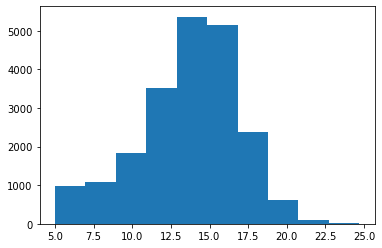

In [70]:
plt.hist(trips['avg_speed'])

In [77]:
clean_data.check_missing(rides_use)

duration: 0 missing of 21026
distance: 0 missing of 21026
elevation_gain: 0 missing of 21026
avg_speed: 0 missing of 21026
max_speed: 0 missing of 21026
if_updated: 0 missing of 21026
photos: 0 missing of 21026
big_user: 0 missing of 21026
crow_distance: 0 missing of 21026
if_weekend: 0 missing of 21026
prop_moving: 0 missing of 21026


In [ ]:
useful_cols = ['distance', 'elevation_gain', 'avg_speed',
               'if_updated', 'photos', 'big_user', 'crow_distance']
rides_use = rides[useful_cols].copy()
rides_use.dtypes
for col in rides_use.columns:
    if rides_use[col].dtype == 'float64':
        rides_use[col] = rides_use[col] / rides_use[col].max()


(array([2.0739e+04, 1.3700e+02, 8.0000e+01, 4.2000e+01, 6.0000e+00,
        1.4000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

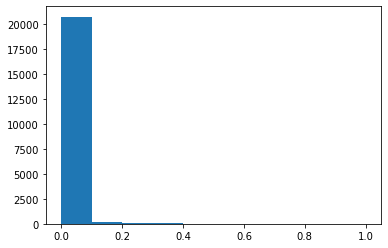

In [72]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
clusterer.fit(rides_use)
print(clusterer.labels_.max())

11


In [74]:
mapped_clusters = sklearn.manifold.TSNE(n_components=2, metric='cosine', init='pca').fit_transform(rides_use)


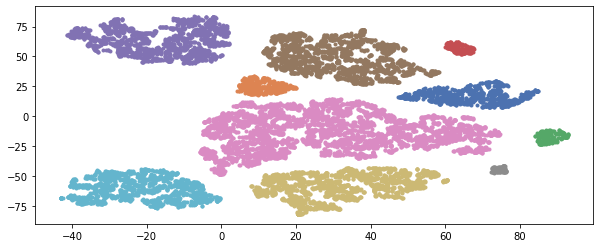

In [75]:
x = mapped_clusters[:, 0]
y = mapped_clusters[:, 1]
# colours = ['firebrick', 'tomato', 'darkorange', 'burlywood',
#           'gold', 'olivedrab', 'darkseagreen', 'darkgreen',
#           'lightseagreen', 'paleturquoise', 'darkslategray',
#           'deepskyblue','steelblue', 'royalblue', 'slateblue',
#           'darkorchid', 'fuchsia', 'palevioletred']
colours = sns.color_palette('deep', 10)
plt.figure(figsize=(10, 4))
for c in range(10):
    plt.plot(x[clusterer.labels_ == c], y[clusterer.labels_ == c], '.', color=colours[c])

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True,
                              selection_palette=colours)

In [ ]:
clusterer.single_linkage_tree_.plot()

In [ ]:
for col in rides.columns:
    print('{}: {} missing'.format(col, rides[col].isna().sum()))

In [ ]:
a = rides.group_membership_id.value_counts()
a[a > 100].index.tolist()

In [ ]:
# rides[rides.if_update > 0].shape
22670 - 21788

In [ ]:
trips = pd.read_csv(config.RAW_DATA_PATH + 'ridewgps_trips.csv')
trips = clean_data.clean_trips(trips)
trips.shape
# routes = pd.read_csv(config.RAW_DATA_PATH + 'ridewgps_routes.csv')
# trip_cols = list(set(trips.columns) - set(routes.columns))

In [ ]:
for col in rides.columns:
    print('{} ({} missing):\n{}'.format(col, rides[col].isna().sum(), rides[col].value_counts()))

In [ ]:
# trips[trips.is_gps == False][['id', 'moving_time', 'duration']]
a = rides.user_id.value_counts()
a[(a > 500)]

In [ ]:
rides.highlighted_photo_id[rides.highlighted_photo_id > 0].shape

In [ ]:
osm = esy.osm.pbf.File('/media/sf_Insight/data/north-america-latest.osm.pbf')
for i, entry in enumerate(osm):
    if i == 2: break
entry

In [ ]:

class CounterHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.num_nodes = 0

    def node(self, n):
        self.num_nodes += 1
        
if __name__ == '__main__':

    h = CounterHandler()
    filename = '/home/emily/Downloads/map_ashokan.xml'
    h.apply_file(filename)

    print("Number of nodes: %d" % h.num_nodes)

In [ ]:
class LatLonHandler(osmium.SimpleHandler):
    def __init__(self):
        super(LatLonHandler).__init__()
        self.latlons = []

    def node(self, n):
        self.latlons.append([o.tags['place']])
        self.num_nodes += 1

filename = '/home/emily/Downloads/map_ashokan.xml'
h = LatLonHandler()
h.apply_file(filename)

In [ ]:
root = tree.getroot()
root[3].text

In [ ]:
node[1].